# Full Strategies Analysis

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TrendFollowingPCs\root\src")
from PCBacktest import PCBacktest

In [3]:
def get_backtest() -> pd.DataFrame: 
    
    pc_backtest = PCBacktest()
    df_out = (pd.concat([
        pc_backtest.get_pc_spread_signal_rtn(),
        pc_backtest.get_pc_ewma_rtn(),
        pc_backtest.get_pc_ewmac_rtn(),
        pc_backtest.get_pc_zscore_rtn(),
        pc_backtest.get_kalman_rtn()]))
    
    return df_out

df_backtest = get_backtest()

In this case we are going to use a full sample positive sharpe cutoff

In [4]:
def get_strategy_pc_sharpe(df_backtest: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_backtest[
        ["variable", "strat_group", "signal_bps"]].
        groupby(["variable", "strat_group"]).
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_sharpe = get_strategy_pc_sharpe(df_backtest)

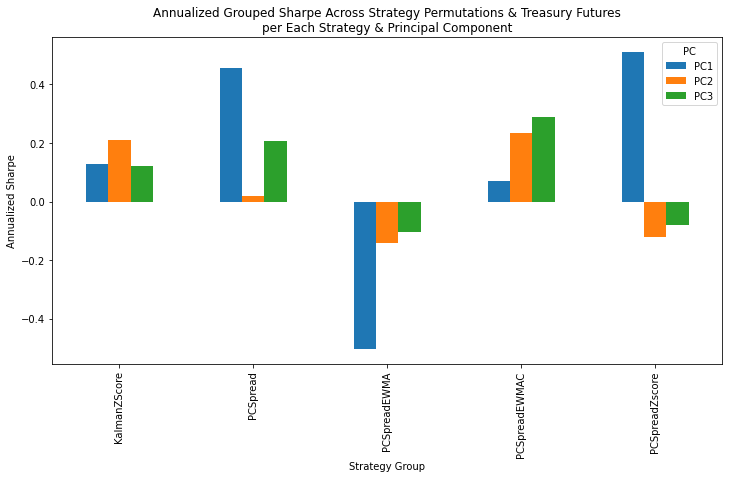

In [5]:
def plot_strategy_pc_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 

    (df_sharpe[
        ["variable", "strat_group", "sharpe"]].
        rename(columns = {"variable": "PC"}).
        pivot(index = "strat_group", columns = "PC", values = "sharpe").
        plot(
            figsize = (12,6),
            kind    = "bar",
            xlabel  = "Strategy Group",
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Grouped Sharpe Across Strategy Permutations & Treasury Futures\nper Each Strategy & Principal Component"))
    
plot_strategy_pc_sharpe(df_sharpe)

First start by filering out those strategies

In [6]:
def filter_strats(df_sharpe: pd.DataFrame, df_backtest: pd.DataFrame) -> pd.DataFrame:
    
    df_filtered = (df_sharpe.query(
        "sharpe > 0")
        [["variable", "strat_group"]].
        merge(right = df_backtest, how = "inner", on = ["variable", "strat_group"]).
        assign(strat_subgroup = lambda x: x.strat_group + " " + x.variable))
    
    return df_filtered

df_filtered = filter_strats(df_sharpe, df_backtest)

Let's start by looking at the correlation across each strategy. In this case just average returns across strategies (which are expressed in basis points).

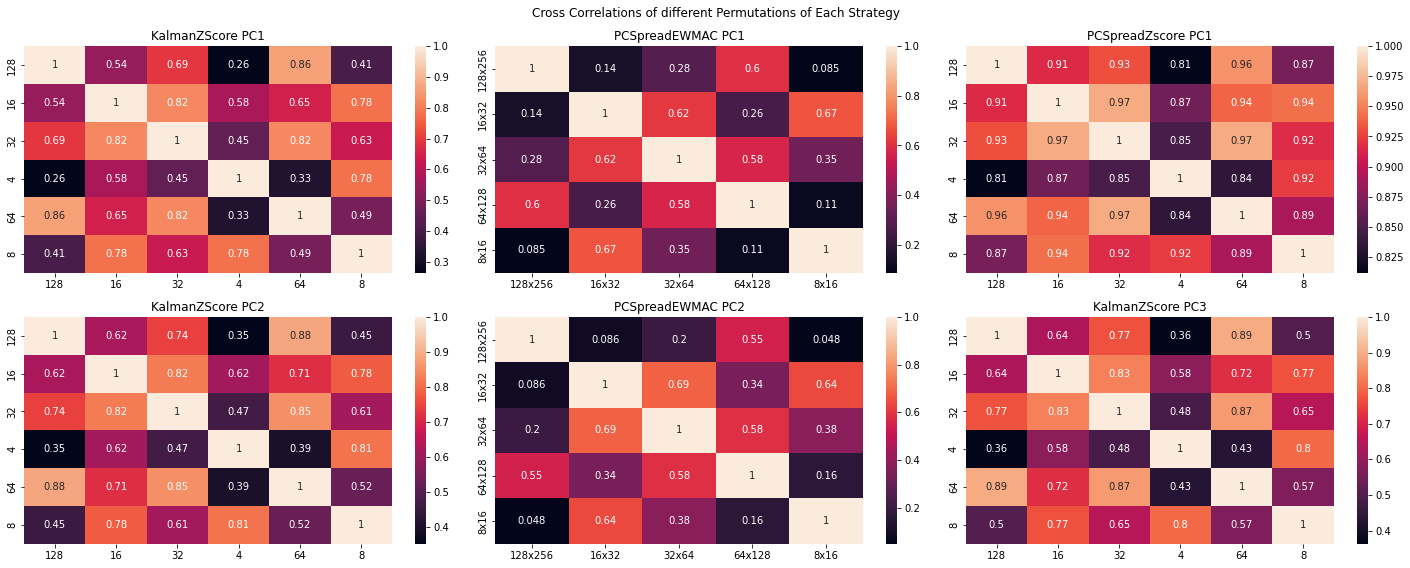

In [10]:
def plot_correlation(df_filtered: pd.DataFrame) -> plt.Figure: 
    
    strat_subgroups = df_filtered.query("strat_group != 'PCSpread'").strat_subgroup.drop_duplicates()
    fig, axes       = plt.subplots(ncols = len(strat_subgroups) // 2, nrows = len(strat_subgroups) // 3, figsize = (20,8))

    for strat_subgroup, ax in zip(strat_subgroups, axes.flatten()):

        df_corr = (df_filtered.query(
            "strat_subgroup == @strat_subgroup")
            [["date", "signal_bps", "strat_name"]].
            assign(strat_name = lambda x: x.strat_name.str.split("_").str[-1]).
            groupby(["date", "strat_name"]).
            agg("mean")
            ["signal_bps"].
            reset_index().
            pivot(index = "date", columns = "strat_name", values = "signal_bps").
            corr())

        sns.heatmap(
            ax          = ax, 
            data        = df_corr,
            annot       = True)

        ax.set_xlabel(""), ax.set_ylabel(""), ax.set_title(strat_subgroup)

    fig.suptitle("Cross Correlations of different Permutations of Each Strategy")
    plt.tight_layout()
    
plot_correlation(df_filtered)

Now create a simple backtest by averaging strategies across returns per each security per each strategy group.

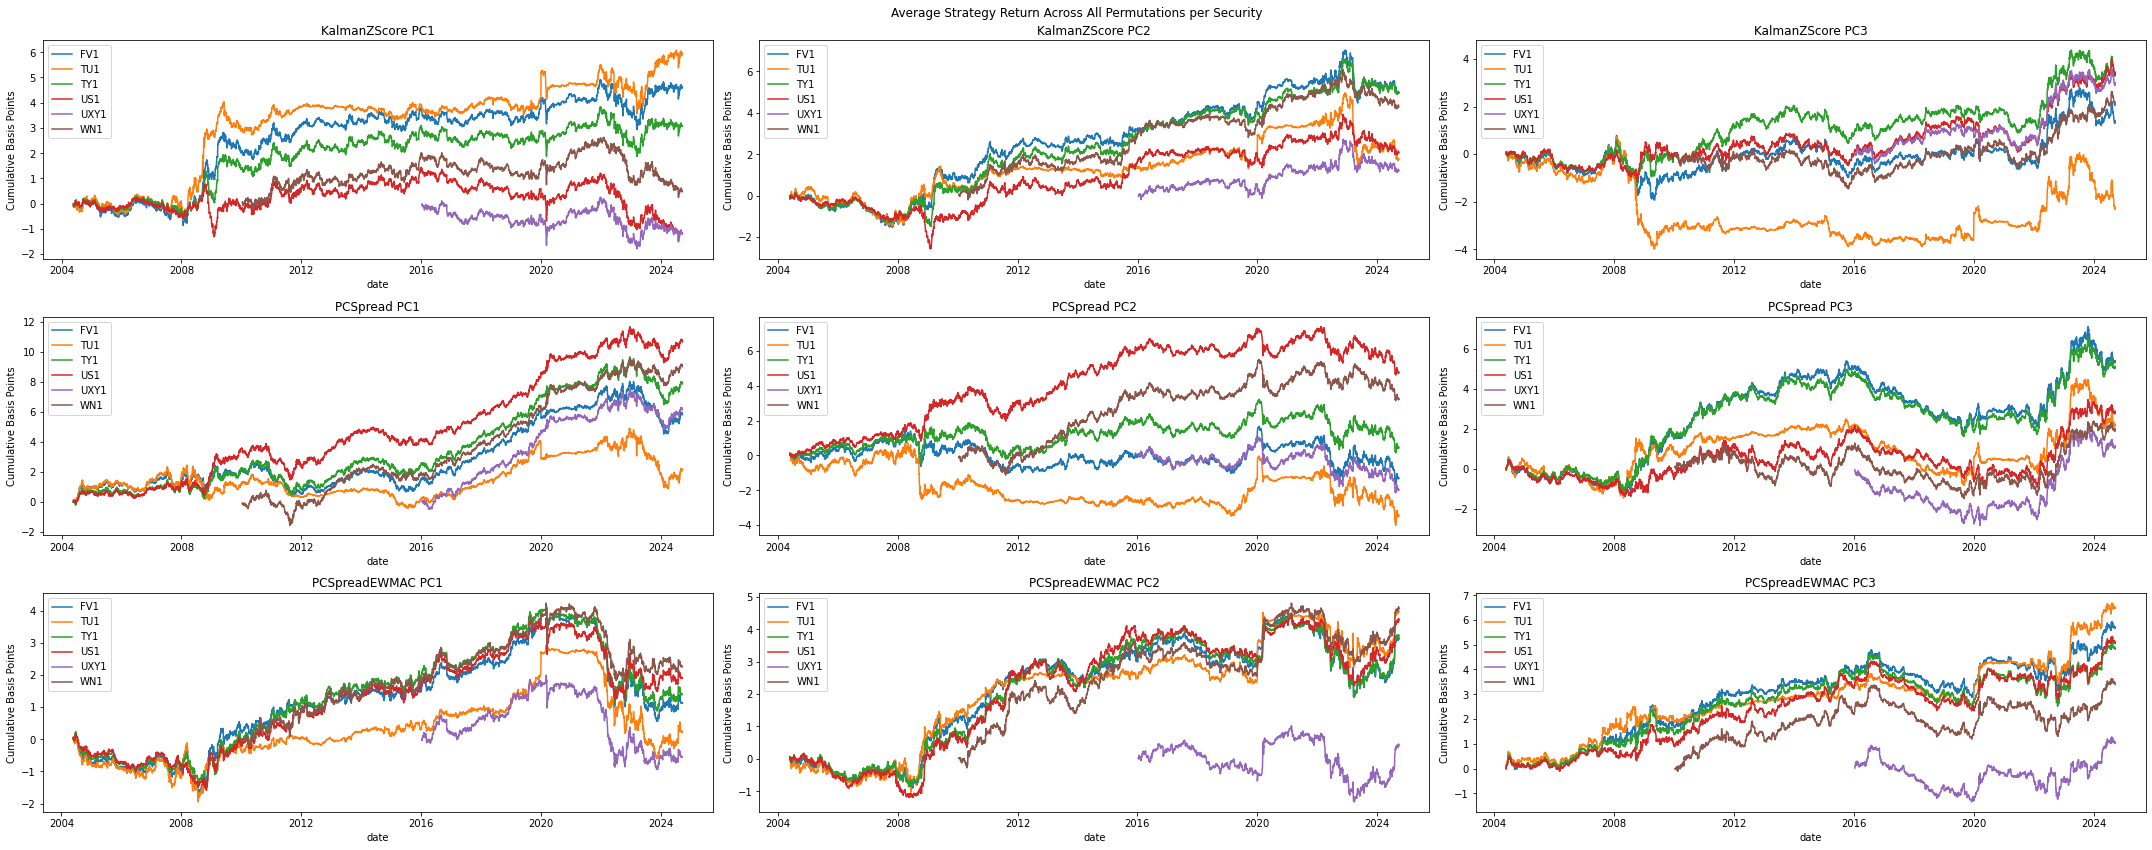

In [33]:
def plot_average_return(df_filtered: pd.DataFrame) -> plt.Figure:
    
    df_tmp = (df_filtered[
        ["strat_subgroup", "date", "signal_bps", "security"]].
        groupby(["strat_subgroup", "date", "security"]).
        agg("mean").
        reset_index())

    strat_subgroups = df_tmp.strat_subgroup.drop_duplicates().to_list()
    fig, axes       = plt.subplots(ncols = len(strat_subgroups) // 3, nrows = len(strat_subgroups) // 3, figsize = (30,12))

    for strat_subgroup, ax in zip(strat_subgroups, axes.flatten()):

        (df_tmp.query(
            "strat_subgroup == @strat_subgroup").
            drop(columns = ["strat_subgroup"]).
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "signal_bps").
            cumsum().
            plot(
                ax     = ax,
                ylabel = "Cumulative Basis Points",
                title  = strat_subgroup))

    fig.suptitle("Average Strategy Return Across All Permutations per Security")
    plt.tight_layout()
    
plot_average_return(df_filtered)